In [1]:
import numpy as np

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_aer.primitives import Sampler
from qiskit_aer.backends import AerSimulator
from qiskit.circuit.library import TwoLocal
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit import transpile, QuantumCircuit

from qiskit_optimization.translators import to_docplex_mp
from docplex.mp.model import Model
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp

import gibbs_optimizer_v2 as opt

In [2]:
mod = Model()
mod = ModelReader.read_model('../../lp_G0_lp_c/seq_1080_c.lp')

#convert linear program to qubo
qp = from_docplex_mp(mod)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
#quboOp, offset = qubo.to_ising()
Q_info = qubo.objective.quadratic.coefficients.copy()
l_diag = qubo.objective.linear
for k in range(qp.get_num_vars()):
    Q_info[k,k] += l_diag[k]

Q = Q_info.tocoo()
scaling = np.abs(np.max(Q))
Q=Q/scaling #scale coefficients
Q_data = np.stack([Q.row, Q.col, Q.data], axis=1)
print(scaling)

281.99999999999994


In [3]:
target_mdl = QuadraticProgram()
target_mdl.read_from_lp_file('../../lp_G0_lp_c/seq_1080_c.lp')

N = target_mdl.get_num_vars()
print(N)
cplex_result = CplexOptimizer().solve(target_mdl)
cplex_optval = cplex_result.fval
cplex_xsol = cplex_result.x.astype(int)

print(
        '-'*110,
        '[CPLEX Result]',
        f'   optimal value: {cplex_optval:.3f}',
        f'   optimal solution (binary): {cplex_xsol}',
        f'   status: {cplex_result.status.name}',
        '-'*110,
        sep='\n'
    )

30
--------------------------------------------------------------------------------------------------------------
[CPLEX Result]
   optimal value: -91.500
   optimal solution (binary): [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1]
   status: SUCCESS
--------------------------------------------------------------------------------------------------------------


In [4]:
def objective(x):
    objval = x @ Q @ x
    return objval

In [5]:
num_qubits = qp.get_num_vars() 
print(f'number of system qubits: {num_qubits}')

number of system qubits: 30


In [6]:
reps = 2

ansatz = TwoLocal(
    num_qubits = num_qubits,
    rotation_blocks = 'ry', 
    entanglement_blocks = 'cz',
    entanglement = 'pairwise', 
    reps = reps,
    insert_barriers = True
    )

n_params = ansatz.num_parameters
print(f'number of params: {n_params}')

number of params: 90


In [7]:
shots = 2**10

from qiskit_aer.primitives import Sampler
sampler = Sampler(backend_options={'method' : 'matrix_product_state', 'n_qubits': num_qubits})
sampler.set_options(shots=shots)

QuantumOptimizer = opt.Quantum_Optimizer()
QuantumOptimizer.set_optimizer(num_qubits, ansatz, sampler)
theta_initial = np.hstack([np.full(num_qubits, np.pi/2), np.zeros(num_qubits*ansatz.reps)])

In [9]:
import time
from collections import defaultdict
import pickle

prob_list = defaultdict(list)
log = defaultdict(list)

for itrial in range(0, 10):
    theta = theta_initial
    for beta in [100.0]:
        st = time.time()
        opt_run = QuantumOptimizer.run(
            objective = objective, 
            qc_params_init = theta,
            scaling = scaling,
            max_epoch = 2,  
            intermediate_result_display = True,
            refval = None,
            alpha = 1.0, #cVAR param
            beta = beta,
        )
        filename = 'log_b_' + str(beta) + '_trial_' + str(itrial)
        with open('benchmark/N30/a_1/' + filename, 'wb') as fp:
            pickle.dump(opt_run, fp)
        
        print(time.time() - st)

epoch 0 	 step 0 	 exp_evals 1 	 cvar 0.007 	 fval -1.4916545884192147 	 fevals 188 	 best val -0.08882978723404257
epoch 0 	 step 1 	 exp_evals 4 	 cvar 0.007 	 fval -1.4862725795614269 	 fevals 882 	 best val -0.08882978723404257
epoch 0 	 step 2 	 exp_evals 7 	 cvar 0.006 	 fval -1.4922691422815897 	 fevals 1551 	 best val -0.09751773049645392
epoch 0 	 step 3 	 exp_evals 10 	 cvar 0.007 	 fval -1.4945474189361063 	 fevals 2165 	 best val -0.09751773049645392
epoch 0 	 step 4 	 exp_evals 13 	 cvar 0.006 	 fval -1.4964419766574997 	 fevals 2878 	 best val -0.09751773049645392
epoch 0 	 step 5 	 exp_evals 16 	 cvar 0.006 	 fval -1.4951276019906339 	 fevals 3565 	 best val -0.1670212765957447
epoch 0 	 step 6 	 exp_evals 19 	 cvar 0.007 	 fval -1.495677485393818 	 fevals 4248 	 best val -0.1670212765957447
epoch 0 	 step 7 	 exp_evals 22 	 cvar 0.006 	 fval -1.4964021554873772 	 fevals 4908 	 best val -0.1670212765957447
epoch 0 	 step 8 	 exp_evals 25 	 cvar 0.006 	 fval -1.4945474189

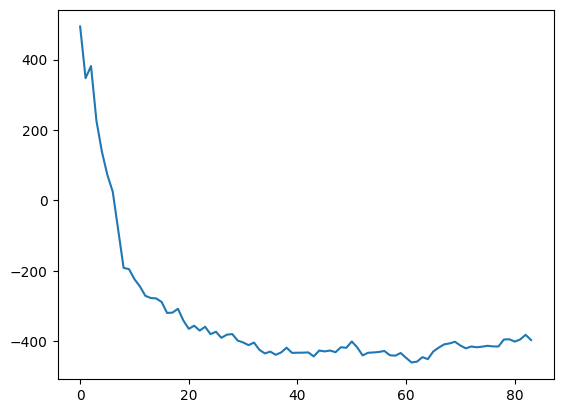

In [17]:
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

for beta in [0.0001, 1.0, 20]:
    all_log = []
    for itrial in range(0, 10):
        filename = 'log_b_' + str(beta) + '_trial_' + str(itrial)
        with open('benchmark/N14/' + filename, 'rb') as fp:
            log = pickle.load(fp)    
        #all_log.append([x for x in log['expec_log']])
        all_log.append([x+y for (x, y) in zip(log['expec_log'], log['entrpy_log'])])
    plt.plot(np.mean(all_log, 0), '-')
    plt.show()
#plt.yscale('log')
#plt.ylim([-92.0, -85.0])
#plt.legend([0.0001, 1.0, 20])

In [18]:
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

for beta in [0.0001, 1.0, 20]:
    all_log = []
    for itrial in range(0, 10):
        filename = 'log_b_' + str(beta) + '_trial_' + str(itrial)
        with open('benchmark/a_1/' + filename, 'rb') as fp:
            log = pickle.load(fp)    
        all_log.append([x for x in log['expec_log']])
        #all_log.append([x+y for (x, y) in zip(log['expec_log'], log['entrpy_log'])])
    plt.plot(np.mean(all_log, 0), '-')
    plt.show()
#plt.yscale('log')
#plt.ylim([-92.0, -85.0])
#plt.legend([0.0001, 1.0, 20])

FileNotFoundError: [Errno 2] No such file or directory: 'benchmark/a_1/log_b_0.0001_trial_0'

In [ ]:
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

for beta in [0.0001, 1.0, 20]:
    all_log = []
    for itrial in range(0, 10):
        filename = 'log_b_' + str(beta) + '_trial_' + str(itrial)
        with open('benchmark/a_1/' + filename, 'rb') as fp:
            log = pickle.load(fp)    
        all_log.append([x for x in log['entrpy_log']])
        #all_log.append([x+y for (x, y) in zip(log['expec_log'], log['entrpy_log'])])
    plt.plot(np.mean(all_log, 0), '-')
    plt.show()
#plt.yscale('log')
#plt.ylim([-92.0, -85.0])
#plt.legend([0.0001, 1.0, 20])

In [ ]:
x = [0.01, 0.1, 1.0, 2.0, 4.0]
plt.plot(x, np.mean(list(all_log.values()), axis=0), '-o')
plt.errorbar(x, np.mean(list(all_log.values()), axis=0), 
                                                 np.std(list(all_log.values()), axis=0), marker='o')
plt.plot(x, [-91.5 for i in x], '-')

In [ ]:
qc = ansatz.bind_parameters(opt_run['theta'])
qc.measure_all()

job = sampler.run(qc)
result = job.result()
quasi_dist = result.quasi_dists[0]
prob_dict = quasi_dist.binary_probabilities()
prob_list[beta].append(prob_dict)  

In [ ]:
from itertools import product
import matplotlib.pyplot as plt

ee = {}
prob = {}

bit_str = [''.join(p) for p in product('10', repeat=num_qubits)]

def energy(x):
    x = np.array(list(x)).astype(int)
    x = np.flip(x) 
    return x @ Q @ x

for beta in np.arange(0.5, 0.6, 0.1):
    Z = 0.0
    for elem in bit_str:
        ee[elem] = objective([int(i) for i in elem])
        prob[elem] = np.exp(-beta * ee[elem])
        Z+= prob[elem]
    
    prob_ee = {k:(v/Z) for (k,v) in zip(ee.values(), prob.values())}
    plt.plot(prob_ee.keys(), prob_ee.values(), 'o')
    plt.plot([energy(x) for x in prob_list[0.5][0].keys()], prob_list[0.5][0].values(), 'o')
    #plt.yscale('log')

In [ ]:
fid = 0.0
for bit_str, val in prob.items():
    if bit_str in prob_list[0.5][0].keys():
        fid+= prob[bit_str] * prob_list[0.5][0][bit_str]
fid

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
list(all_log.values())